In [2]:
import scanpy as sc
import pandas as pd
import os
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy.stats import ttest_ind, wilcoxon, mannwhitneyu

In [4]:
## path to repository
os.chdir('/hpcnfs/scratch/DIMA/piva/mpi_freiburg/scmultiome/')

In [5]:

## already Normalized ATAC assay
adata_path='./data/WT_ONLY_scmultiome_norm_ATACassay.h5ad' # path to the normalized ATAC assay, peaks are called in WT cells only
adata=sc.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 13931 × 43277
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'pANN_0.25_0.09_556', 'doublets', 'dataset', 'pANN_0.25_0.09_978', 'pANN_0.25_0.09_143', 'pANN_0.25_0.09_477', 'pANN_0.25_0.09_359', 'pANN_0.25_0.09_20', 'pANN_0.25_0.09_136', 'pANN_0.25_0.09_70', 'pANN_0.25_0.09_1488', 'pANN_0.25_0.09_1159', 'pANN_0.25_0.09_399', 'pANN_0.25_0.09_832', 'sample', 'stage', 'replicate', 'nCount_ATAC', 'nFeature_ATAC', 'integrated_snn_res.0.8', 'annotation_leiden12', 'nCount_peaks', 'nFeature_peaks', 'ident'
    uns: 'X_name'
    layers: 'logcounts'

In [6]:
adata.var['chr']=[e.split('-')[0] for e in adata.var.index.tolist()]
adata.var['start']=[e.split('-')[-2] for e in adata.var.index.tolist()]
adata.var['end']=[e.split('-')[-1] for e in adata.var.index.tolist()]

In [7]:
adata.var

,chr,start,end
chr2L-563-1274,chr2L,563,1274
chr2L-1648-2058,chr2L,1648,2058
chr2L-5334-6147,chr2L,5334,6147
chr2L-7459-9247,chr2L,7459,9247
chr2L-12064-12996,chr2L,12064,12996
...,...,...,...
chrY-3653011-3653695,chrY,3653011,3653695
chrY-3654745-3655231,chrY,3654745,3655231
chrY-3655664-3656275,chrY,3655664,3656275
chrY-3665573-3666557,chrY,3665573,3666557


## peaks associated to HVGs

In [8]:

peaksgenes=pd.read_csv("./data/hvgs2000_1st_linked_peak_enh_within20kb.csv", 
                      ).drop('Unnamed: 0', axis=1)      # path to the peaks of enhancers of high variable genes

peaksgenes.head()

,genes,linked_peaks
0,FBgn0032629,chr2L-17262257-17262900
1,FBgn0003411,chrX-11728914-11730370
2,FBgn0086690,chr3L-15080826-15081498
3,FBgn0035572,chr3L-4283259-4284155
4,FBgn0014135,chr3R-19838801-19839419


In [7]:
peaksgenes.shape

(620, 2)

In [9]:
tss_peaks=pd.read_csv("./data/atac_peaks_associated_to_HVgenes_500KB_TSS.bed",
                      header=None, sep='\t')  # path to the peaks of TSS of high variable genes
tss_peaks.rename(columns={0:'seqnames', 1:'start', 2:'end', 3:'gene'}, inplace=True)
tss_peaks['start']=tss_peaks['start']+1
tss_peaks['peak']=tss_peaks['seqnames'].astype(str)+'-'+tss_peaks['start'].astype(str)+'-' +tss_peaks['end'].astype(str)


tss_peaks

,seqnames,start,end,gene,4,5,peak
0,chr2L,87113,87331,net,0,.,chr2L-87113-87331
1,chr2L,87113,87331,net,0,.,chr2L-87113-87331
2,chr2L,87113,87331,net,0,.,chr2L-87113-87331
3,chr2L,87113,87331,net,0,.,chr2L-87113-87331
4,chr2L,87464,87676,net,0,.,chr2L-87464-87676
...,...,...,...,...,...,...,...
36934,chrX,22854922,22856426,fog,0,.,chrX-22854922-22856426
36935,chrX,22854922,22856426,fog,0,.,chrX-22854922-22856426
36936,chrX,22854922,22856426,fog,0,.,chrX-22854922-22856426
36937,chrX,22854922,22856426,fog,0,.,chrX-22854922-22856426


In [10]:
tss_peaks['gene'].nunique()

1919

In [11]:
import matplotlib
import seaborn as sns
cmap_greygreen = matplotlib.colors.LinearSegmentedColormap.from_list("", 
                                        list(sns.color_palette('Greys',19))[0:5]+['#45ba62']) #+list(sns.color_palette('Greens',5))[2:4])
 

# Correlation GEX and single PEAK

In [12]:
import scanpy as sc
import pandas as pd
import os
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind, wilcoxon, mannwhitneyu

In [13]:
# import the normalized RNA assay
adata_gex=sc.read_h5ad('./data/adata_RNAassay_normalized.h5ad')
adata_gex

AnnData object with n_obs × n_vars = 22358 × 17807
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'pANN_0.25_0.09_556', 'doublets', 'dataset', 'pANN_0.25_0.09_978', 'pANN_0.25_0.09_143', 'pANN_0.25_0.09_477', 'pANN_0.25_0.09_359', 'pANN_0.25_0.09_20', 'pANN_0.25_0.09_136', 'pANN_0.25_0.09_70', 'pANN_0.25_0.09_1488', 'pANN_0.25_0.09_1159', 'pANN_0.25_0.09_399', 'pANN_0.25_0.09_832', 'sample', 'stage', 'replicate', 'nCount_ATAC', 'nFeature_ATAC', 'integrated_snn_res.0.8', 'ident', 'annotation_leiden12', 'group'
    var: 'FLYBASE'
    uns: 'X_name', 'log1p'
    obsm: 'X_umap'
    layers: 'logcounts'

In [15]:
## Conversion to gene symbol
conv=pd.read_csv('./data/main_genesymbol.csv', sep='\t')
conv_dict=dict(zip(conv['validated_id'],conv['current_symbol']))

In [16]:
peaksgenes['symbol']=peaksgenes['genes'].map(conv_dict)
tss_peaks['fb_genes']=tss_peaks['gene'].map(dict(zip( adata_gex.var.index, adata_gex.var['FLYBASE'],)))

In [17]:
tss_peaks[tss_peaks['fb_genes'].isna()]['gene'].nunique()

73

In [18]:
peaksgenes.head()

,genes,linked_peaks,symbol
0,FBgn0032629,chr2L-17262257-17262900,beat-IIIc
1,FBgn0003411,chrX-11728914-11730370,sisA
2,FBgn0086690,chr3L-15080826-15081498,Plp
3,FBgn0035572,chr3L-4283259-4284155,CG13711
4,FBgn0014135,chr3R-19838801-19839419,bnl


In [19]:
tss_peaks.head()

,seqnames,start,end,gene,4,5,peak,fb_genes
0,chr2L,87113,87331,net,0,.,chr2L-87113-87331,FBgn0002931
1,chr2L,87113,87331,net,0,.,chr2L-87113-87331,FBgn0002931
2,chr2L,87113,87331,net,0,.,chr2L-87113-87331,FBgn0002931
3,chr2L,87113,87331,net,0,.,chr2L-87113-87331,FBgn0002931
4,chr2L,87464,87676,net,0,.,chr2L-87464-87676,FBgn0002931


In [20]:
len([ e for e in peaksgenes['genes'].tolist() if e in tss_peaks['fb_genes'].tolist()])

507

In [21]:

# adata_gex.var['symbol']=adata_gex.var.index.map(conv_dict)
# adata_gex.var.loc[adata_gex.var[adata_gex.var['symbol'].isna()].index,'symbol']=adata_gex.var.loc[adata_gex.var[adata_gex.var['symbol'].isna()].index].index
adata_gex.var['symbol']=adata_gex.var.index
adata_gex.var.set_index('FLYBASE',inplace=True)

In [23]:
adata_gex.var

,symbol
FLYBASE,
FBgn0267431,Myo81F
FBgn0085804,CR41571
FBgn0039987,CR12798
FBgn0267798,lncRNA:CR46123
FBgn0267797,lncRNA:CR46122
...,...
FBgn0267595,CR45933
FBgn0259864,Su(Ste):CR42433
FBgn0085506,CG40635


# Boxplot correlations TSS and Enhancers

In [24]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [25]:
df_genes1=sc.get.obs_df(adata[adata.obs['sample']=='wt'], ['annotation_leiden12']+
                                                           peaksgenes['linked_peaks'].tolist() + tss_peaks['peak'].tolist() )
df_genes2=sc.get.obs_df(adata_gex[adata_gex.obs['sample']=='wt'], 
                        peaksgenes['genes'].unique().tolist() + tss_peaks['fb_genes'].dropna().unique().tolist()
                       )

df_genes1=df_genes1.merge(df_genes2, left_index=True, right_index=True)
df_genes1=df_genes1.loc[:,~df_genes1.columns.duplicated()]

In [26]:
df_genes2.shape

(13931, 2466)

In [27]:
df_genes1.shape

(13931, 4850)

In [28]:
df_genes1.head()

,annotation_leiden12,chr2L-17262257-17262900,chrX-11728914-11730370,chr3L-15080826-15081498,chr3L-4283259-4284155,chr3R-19838801-19839419,chr3R-8203010-8203866,chr2L-13243245-13245486,chrX-15018768-15019940,chr2L-17755520-17756119,...,FBgn0031132,FBgn0085387,FBgn0031142,FBgn0031170,FBgn0266457,FBgn0024807,FBgn0265923,FBgn0052499,FBgn0266348,FBgn0262237
wt.5.1_AAACAGCCACCAAAGG-1,anterior_endoderm,0.0,2.841465,0.000000,1.905494,0.000000,0.000000,0.000000,1.895206,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wt.5.1_AAACAGCCACGGTACT-1,mesoderm,0.0,0.000000,3.250592,1.881441,0.000000,0.000000,0.981911,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wt.5.1_AAACAGCCAGCAATAA-1,ventral_ectoderm,0.0,2.225240,0.000000,0.000000,0.000000,0.000000,0.000000,1.914525,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wt.5.1_AAACAGCCATAGGCGA-1,neuroectoderm,0.0,0.000000,0.000000,2.160088,0.000000,0.000000,1.723655,0.000000,2.535306,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wt.5.1_AAACAGCCATCGCTCC-1,dorsal_ectoderm,0.0,0.000000,2.573793,0.000000,2.411884,2.304722,1.449679,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## pseudobulk

In [29]:

# group by mean to do pseudobulk
df_genes1=df_genes1.groupby('annotation_leiden12').mean()


/var/tmp/pbs.2120434.hpcfe01/ipykernel_4399/3944305276.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_genes1=df_genes1.groupby('annotation_leiden12').mean()


In [30]:
df_genes1

,chr2L-17262257-17262900,chrX-11728914-11730370,chr3L-15080826-15081498,chr3L-4283259-4284155,chr3R-19838801-19839419,chr3R-8203010-8203866,chr2L-13243245-13245486,chrX-15018768-15019940,chr2L-17755520-17756119,chr3R-15987964-15989749,...,FBgn0031132,FBgn0085387,FBgn0031142,FBgn0031170,FBgn0266457,FBgn0024807,FBgn0265923,FBgn0052499,FBgn0266348,FBgn0262237
annotation_leiden12,,,,,,,,,,,,,,,,,,,,,
anterioposterior_ectoderm,0.259078,0.392701,0.207522,0.639920,0.315607,0.252338,0.787316,0.604541,0.086283,0.940159,...,0.000000,0.170815,0.017065,0.156669,0.051200,0.274012,0.000000,0.000000,0.017343,0.0
anterior_endoderm,0.363181,0.312064,0.212546,0.621597,0.134826,0.833912,0.692686,0.555638,0.148850,0.762698,...,0.000000,0.058703,0.011493,0.105951,0.052316,0.355584,0.003948,0.007224,0.000000,0.0
dorsal_ectoderm,0.161039,0.338126,0.199284,0.476587,0.502689,0.630514,0.662910,0.557339,0.096865,0.947846,...,0.000000,0.099855,0.009519,0.103984,0.057989,0.395269,0.013835,0.009673,0.005392,0.0
mesoderm,0.268060,0.326426,0.182102,0.571159,0.211372,0.250884,0.711619,0.579138,0.661385,0.692253,...,0.000000,0.110401,0.002624,0.066551,0.083159,0.351469,0.000000,0.009950,0.022427,0.0
neuroectoderm,0.197823,0.303849,0.191512,0.535806,0.279403,0.335501,0.696894,0.561076,0.123091,0.740427,...,0.000000,0.046972,0.009821,0.100238,0.043990,0.380054,0.002937,0.006958,0.008634,0.0
posterior_endoderm,0.413268,0.275389,0.278383,0.598864,0.158552,0.249836,0.795989,0.532665,0.187361,1.046083,...,0.008622,0.090251,0.000000,0.064446,0.039083,0.315271,0.007631,0.000000,0.023631,0.0
undifferentiated_cells,0.107643,0.149862,0.146162,0.444643,0.146591,0.105361,0.526934,0.408400,0.050361,0.741621,...,0.000000,0.057555,0.000000,0.000000,0.000000,0.128621,0.000000,0.025372,0.000000,0.0
ventral_ectoderm,0.222940,0.262307,0.289698,0.651239,0.193178,0.411972,0.766456,0.508130,0.083347,0.861957,...,0.000000,0.037853,0.004677,0.056127,0.051332,0.258742,0.009039,0.008147,0.008848,0.0
yolk,1.173277,0.741448,0.861042,0.965988,0.071454,0.134398,1.210295,1.235565,0.107872,1.433248,...,0.000000,0.142471,0.000000,0.145241,0.000000,0.251051,0.000000,0.000000,0.000000,0.0


In [31]:
peaksgenes.set_index('genes', inplace=True)#[['linked_peaks']]
peaksgenes[['linked_peaks']]

,linked_peaks
genes,
FBgn0032629,chr2L-17262257-17262900
FBgn0003411,chrX-11728914-11730370
FBgn0086690,chr3L-15080826-15081498
FBgn0035572,chr3L-4283259-4284155
FBgn0014135,chr3R-19838801-19839419
...,...
FBgn0030251,chrX-11338851-11340124
FBgn0038385,chr3R-15653605-15655433
FBgn0041781,chr2L-11088550-11089054


In [32]:
## Correlations enhancers

corr_enh=[]
for gene in peaksgenes.index.tolist():
    peak=peaksgenes.at[gene, 'linked_peaks']

    df=df_genes1[(df_genes1[gene]>0 ) & (df_genes1[peak]>0)]
    if df.shape[0] >2:
        r,p=spearmanr(df[gene], df[peak])
        #print(gene, peak, r)
    else:
        r=np.NaN
        
    corr_enh.append(r)

peaksgenes['1st_linked_enh_correlation']=corr_enh


In [33]:
peaksgenes.head()

,linked_peaks,symbol,1st_linked_enh_correlation
genes,,,
FBgn0032629,chr2L-17262257-17262900,beat-IIIc,0.666667
FBgn0003411,chrX-11728914-11730370,sisA,-0.300000
FBgn0086690,chr3L-15080826-15081498,Plp,0.233333
FBgn0035572,chr3L-4283259-4284155,CG13711,0.333333
FBgn0014135,chr3R-19838801-19839419,bnl,0.833333


In [34]:
tss_peaks

,seqnames,start,end,gene,4,5,peak,fb_genes
0,chr2L,87113,87331,net,0,.,chr2L-87113-87331,FBgn0002931
1,chr2L,87113,87331,net,0,.,chr2L-87113-87331,FBgn0002931
2,chr2L,87113,87331,net,0,.,chr2L-87113-87331,FBgn0002931
3,chr2L,87113,87331,net,0,.,chr2L-87113-87331,FBgn0002931
4,chr2L,87464,87676,net,0,.,chr2L-87464-87676,FBgn0002931
...,...,...,...,...,...,...,...,...
36934,chrX,22854922,22856426,fog,0,.,chrX-22854922-22856426,FBgn0000719
36935,chrX,22854922,22856426,fog,0,.,chrX-22854922-22856426,FBgn0000719
36936,chrX,22854922,22856426,fog,0,.,chrX-22854922-22856426,FBgn0000719
36937,chrX,22854922,22856426,fog,0,.,chrX-22854922-22856426,FBgn0000719


In [35]:
gene2tss=pd.DataFrame(tss_peaks).groupby('fb_genes')['peak'].apply(list)
gene2tss=pd.DataFrame(gene2tss)
gene2tss.head()

,peak
fb_genes,
FBgn0000008,"[chr2R-22136674-22137220, chr2R-22136674-22137..."
FBgn0000014,"[chr3R-16827228-16827795, chr3R-16827228-16827..."
FBgn0000015,"[chr3R-16963502-16964007, chr3R-16963502-16964..."
FBgn0000017,"[chr3L-16647543-16648246, chr3L-16647543-16648..."
FBgn0000022,[chrX-369452-370684]


In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
## Correlation most accessible TSS
most_TSS={}
corr_tss=[]
for gene in gene2tss.index.tolist():
    list_peak=gene2tss.at[gene, 'peak']
    corr_tss_gene=[]
    
    ## select the 1st TSS
    peak=list_peak[np.argmax(df_genes1[list_peak].mean())]
    
    most_TSS[gene]=peak
    df=df_genes1[(df_genes1[gene]>0 ) & (df_genes1[peak]>0)]
    if len(df)>1:
        r,p=spearmanr(df[gene],df[peak])
        corr_tss_gene.append(r)
    
    corr_tss.append(np.mean(corr_tss_gene))

gene2tss['1st_tss_correlation']=corr_tss
#gene2tss

In [38]:
gene2tss.head()

,peak,1st_tss_correlation
fb_genes,,
FBgn0000008,"[chr2R-22136674-22137220, chr2R-22136674-22137...",0.238095
FBgn0000014,"[chr3R-16827228-16827795, chr3R-16827228-16827...",0.066667
FBgn0000015,"[chr3R-16963502-16964007, chr3R-16963502-16964...",0.050000
FBgn0000017,"[chr3L-16647543-16648246, chr3L-16647543-16648...",0.500000
FBgn0000022,[chrX-369452-370684],-0.238095


In [39]:
# most_TSS=pd.DataFrame.from_dict(most_TSS,orient='index').reset_index()
# most_TSS.columns=['gene','TSS']
# most_TSS.to_csv('/hpcnfs/scratch/DIMA/piva/mpi_freiburg/WT_ONLY_most_accessible_TSS.csv')

In [40]:
genes_tss_enh=gene2tss.merge(peaksgenes,left_index=True, right_index=True, how='outer' )
genes_tss_enh.head()

,peak,1st_tss_correlation,linked_peaks,symbol,1st_linked_enh_correlation
FBgn0000008,"[chr2R-22136674-22137220, chr2R-22136674-22137...",0.238095,NaN,NaN,NaN
FBgn0000014,"[chr3R-16827228-16827795, chr3R-16827228-16827...",0.066667,chr3R-16821650-16822716,abd-A,0.716667
FBgn0000015,"[chr3R-16963502-16964007, chr3R-16963502-16964...",0.050000,chr3R-16921176-16921939,Abd-B,0.450000
FBgn0000017,"[chr3L-16647543-16648246, chr3L-16647543-16648...",0.500000,chr3L-16410177-16412041,Abl,-0.100000
FBgn0000022,[chrX-369452-370684],-0.238095,NaN,NaN,NaN


In [41]:
genes_tss_enh.shape

(1959, 5)

## All associated enhancers

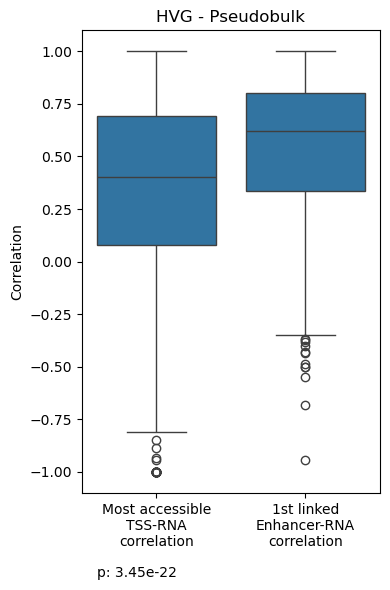

In [59]:
fig,axs=plt.subplots(1,1,figsize=(4,6))
data_for_plot=pd.melt(genes_tss_enh[['1st_tss_correlation', '1st_linked_enh_correlation']])
sns.boxplot( x='variable',y= 'value', data=data_for_plot)
plt.xlabel('')
plt.ylabel('Correlation')
plt.xticks(ticks=[0,1], labels=['Most accessible\nTSS-RNA\ncorrelation','1st linked\nEnhancer-RNA\ncorrelation'])
plt.title('HVG - Pseudobulk')

pval=mannwhitneyu( genes_tss_enh['1st_tss_correlation'], genes_tss_enh['1st_linked_enh_correlation'],nan_policy='omit').pvalue
plt.text(x=-0.4, y=-1.5, s='p: %.2e'%(pval))

#plt.title('single cell')
#plt.ylim(-0.2,1.2)
plt.tight_layout()
plt.savefig('./figures/boxplot_pseudobulk_1stTSS_1stEnh_spearmancorr.pdf')